# VAR Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from matplotlib.pyplot import figure


from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, OrdinalEncoder, MaxAbsScaler

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS


In [2]:
ipe_df = pd.read_csv('data/15_min_data_HFF/IPE 15 min 2022-08-08.csv')
ipe_df

,contTime,Turb_FNU,TurbDailyMn,TurbSamp_NTU,Chloro_RFU,ChloroDailyMn,BGA_RFU,BGADailyMn,ODO_mgL,ODODailyMn,...,Temp_C_raw,Cond_muSCm_raw,TDS_mgL_raw,TotalPres_psi_raw,Turb_avdymn,Chlor_avdymn,Cyano_avdymn,Temp_avdymn,ODO_avdymn,Cond_avdymn
0,2014-06-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-06-20 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-06-20 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-06-20 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-06-20 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285217,2022-08-07 23:00:00,5.48,NaN,NaN,0.34,NaN,0.02,NaN,7.49,NaN,...,18.66,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285218,2022-08-07 23:15:00,5.74,NaN,NaN,0.27,NaN,0.03,NaN,7.48,NaN,...,18.64,123.5,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285219,2022-08-07 23:30:00,6.37,NaN,NaN,0.29,NaN,0.03,NaN,7.47,NaN,...,18.64,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN
285220,2022-08-07 23:45:00,6.40,NaN,NaN,0.34,NaN,0.02,NaN,7.48,NaN,...,18.63,123.4,0.09,13.17,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
ipe_df = ipe_df.rename(columns={'contTime': 'date'})
ipe_df['date'] = pd.to_datetime(ipe_df.date)
data = ipe_df.drop(['date'], axis=1)
data.index = ipe_df.date

In [4]:
ipe_daily = data.resample('D').mean()

In [5]:
ipe_daily = ipe_daily.drop(['TurbDailyMn', 'TurbSamp_NTU',
       'ChloroDailyMn', 'BGADailyMn', 'ODODailyMn',
       'TempDailyMn', 'CondDailyMn', 'TDS_mgL',
       'TotalPres_psi', 'AshtonAirPres_psi', 'Depth_ft', 'Shift_psi',
       'Turb_FNU_raw', 'Chloro_RFU_raw', 'BGA_RFU_raw', 'ODO_mgL_raw',
       'Temp_C_raw', 'Cond_muSCm_raw', 'TDS_mgL_raw', 'TotalPres_psi_raw',
       'Turb_avdymn', 'Chlor_avdymn', 'Cyano_avdymn', 'Temp_avdymn',
       'ODO_avdymn', 'Cond_avdymn'], axis=1)

In [6]:
ipe_interp = ipe_daily.interpolate(method='spline', order=2)

In [7]:
ipe_train = ipe_interp['2016':'2020']

In [8]:
ipe_test = ipe_interp['2021']

C:\Users\harri\AppData\Local\Temp\ipykernel_5124\3605300567.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ipe_test = ipe_interp['2021']


In [9]:
# import island park dam hydrology data
hydro_df = pd.read_csv('data/IslandPark.TS.csv')

# set the datetime to the index
hydro_df['date'] = pd.to_datetime(hydro_df['date'])
hydro_df.set_index(['date'], inplace=True)
hydro_df.index.names = ['date']
hydro_df.columns

Index(['elevation.ft', 'volume.af', 'smoothed.vol', 'smoothed.elev',
       'surfacearea.acres', 'net.evap.af', 'delta.V.af', 'regQ.cfs',
       'gain.cfs', 'smoothed.natQ.cfs'],
      dtype='object')

In [10]:
# drop redundant columns
hydro_df.drop(['volume.af', 'smoothed.vol', 
                   'smoothed.elev', 'surfacearea.acres'], axis=1, inplace=True)

In [11]:
hydro_df = hydro_df['2014':'2022']

In [12]:
# set the range of the data to the same as the sonde data
hydro_interp = hydro_df.interpolate(method='spline', order=2)

In [13]:
# calculate exposed shoreline
#hydro_interp['exposed_shore'] = 8000 - hydro_interp['surfacearea.acres']

In [14]:
hydro_df_train = hydro_interp['2016':'2020']

In [15]:
hydro_df_test = hydro_interp['2021']

C:\Users\harri\AppData\Local\Temp\ipykernel_5124\1673822024.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  hydro_df_test = hydro_interp['2021']


In [16]:
climate_df = pd.read_csv('data/Clean.Climate.TS.csv')
climate_df['Date'] = pd.to_datetime(climate_df['Date'])
climate_df.set_index(['Date'], inplace=True)
climate_df.drop(['GT.TAVE', 'GT.TMIN', 'GT.TMAX', 'GT.DP', 'GT.AP', 'GT.SWE', 'PB.TAVE',
       'PB.TMIN', 'PB.TMAX', 'PB.DP','HFW.AP', 'TR.SWE', 'FR.SWE', 'HF.SWE', 'HFW.SWE', 'AG.DP', 'AG.ET',
       'HFW.Cum.P', 'AG.Cum.P', 'AG.Cum.ET', 'PB.AP', 'PB.SWE', 'BB.TAVE', 'BB.TMIN', 'BB.TMAX', 'BB.DP', 'BB.AP',
       'BB.SWE', 'LL.TAVE', 'LL.TMIN', 'LL.TMAX', 'LL.DP', 'LL.AP', 'LL.SWE', 'GL.TAVE',
       'GL.TMIN', 'GL.TMAX', 'GL.DP', 'GL.AP', 'GL.SWE', 'PC.TAVE', 'PC.TMIN', 'PC.TMAX',
       'PC.DP', 'PC.AP', 'PC.SWE', 'AL.TAVE', 'AL.TMIN', 'AL.TMAX', 'AL.DP', 'AL.AP',
       'AS.TAVE', 'AS.TMIN', 'AS.TMAX', 'AS.DP', 'AS.AP', 'AS.ET', 'RX.TAVE',
       'RX.TMIN', 'RX.TMAX', 'RX.DP', 'RX.AP', 'RX.ET', 'TR.TAVE', 'FR.TAVE',
       'HF.TAVE', 'VA.TAVE', 'HFW.TAVE', 'TR.TMIN', 'FR.TMIN', 'HF.TMIN',
       'VA.TMIN', 'HFW.TMIN', 'TR.TMAX', 'FR.TMAX', 'HF.TMAX', 'VA.TMAX',
       'HFW.TMAX', 'TR.DP', 'FR.DP', 'HF.DP', 'VA.DP', 'HFW.DP', 'TR.AP',
       'FR.AP', 'HF.AP', 'VA.AP', 'WE.TMIN', 'WE.TMAX', 'CC.TMIN', 'CC.TMAX',
       'IP.TMIN', 'IP.TMAX'], axis=1, inplace=True)
climate_df.index.names = ['date']
climate_df.columns

Index(['WE.TAVE', 'WE.DP', 'WE.AP', 'WE.SWE', 'CC.TAVE', 'CC.DP', 'CC.AP',
       'CC.SWE', 'IP.TAVE', 'IP.DP', 'IP.AP', 'IP.SWE'],
      dtype='object')

In [17]:
climate_df = climate_df['2014':'2022']

In [18]:
clim_interp = climate_df.interpolate(method='spline', order=2)

In [19]:
climate_df_train = clim_interp['2016':'2020']

In [20]:
climate_df_test = clim_interp['2021']

C:\Users\harri\AppData\Local\Temp\ipykernel_5124\3356747189.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  climate_df_test = clim_interp['2021']


In [21]:
ipe_train

,Turb_FNU,Chloro_RFU,BGA_RFU,ODO_mgL,Temp_C,Cond_muSCm
date,,,,,,
2016-01-01,3.102660,2.183437,0.414479,10.745625,3.837323,141.426042
2016-01-02,3.067604,1.616771,0.343750,10.761146,3.853583,141.876042
2016-01-03,2.683125,1.437579,0.331771,10.710938,4.008771,143.057292
2016-01-04,2.285312,1.182526,0.215104,10.576771,4.066344,143.029167
2016-01-05,2.225938,1.189271,0.254583,10.527188,4.116604,142.786458
...,...,...,...,...,...,...
2020-12-27,4.713474,0.442796,0.638495,6.953474,3.495432,138.068421
2020-12-28,4.657604,0.481429,0.708132,6.885625,3.478885,137.610417
2020-12-29,4.382604,0.449896,0.640842,6.684062,3.506271,137.482292


In [22]:
final_train = pd.merge(climate_df_train, hydro_df_train, on=['date'])
final_train = pd.merge(final_train, ipe_train, on=['date'])

In [23]:
final_test = pd.merge(climate_df_test, hydro_df_test, on=['date'])
final_test = pd.merge(final_test, ipe_test, on=['date'])

In [24]:
final_test

,WE.TAVE,WE.DP,WE.AP,WE.SWE,CC.TAVE,CC.DP,CC.AP,CC.SWE,IP.TAVE,IP.DP,...,delta.V.af,regQ.cfs,gain.cfs,smoothed.natQ.cfs,Turb_FNU,Chloro_RFU,BGA_RFU,ODO_mgL,Temp_C,Cond_muSCm
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,16.0,0.0,8.2,7.3,19.0,0.0,4.0,3.6,23.0,0.0,...,286.371429,336.0,473.218701,450.186231,4.062128,0.367234,0.577872,6.902447,3.568787,136.174468
2021-01-02,19.0,0.2,8.4,7.6,20.0,0.3,4.3,3.9,24.0,0.3,...,311.414286,331.0,395.996470,437.342115,4.080745,0.375833,0.578333,6.966354,3.563354,135.673958
2021-01-03,22.0,0.4,8.8,7.9,24.0,0.1,4.4,4.0,27.0,0.3,...,305.214286,329.0,390.736122,441.850473,4.290000,0.358333,0.582187,6.949583,3.566958,135.616667
2021-01-04,25.0,0.7,9.5,8.6,26.0,0.4,4.8,4.5,30.0,0.3,...,296.328571,317.0,374.016665,446.983281,4.392083,0.338125,0.583333,6.870833,3.595531,135.275000
2021-01-05,23.0,0.6,10.1,9.0,25.0,0.2,5.0,4.7,29.0,0.4,...,288.200000,335.0,359.163160,441.158729,4.609674,0.344130,0.589783,7.111739,3.626120,135.434783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,10.0,0.5,17.3,12.9,13.0,0.4,11.5,6.5,17.0,0.6,...,345.381446,217.0,227.585681,315.894845,6.513646,0.608750,-0.044271,7.552292,3.786125,133.888542
2021-12-28,2.0,0.0,17.3,13.0,3.0,0.0,11.5,6.5,9.0,0.0,...,333.787929,226.0,392.313095,308.990468,6.322292,0.511563,-0.044167,7.495729,3.791698,133.850000
2021-12-29,6.0,0.3,17.6,13.3,8.0,0.1,11.6,6.6,11.0,0.3,...,304.581729,229.0,299.410937,320.837058,6.224894,0.510319,-0.062872,7.367872,3.828872,134.678723


In [25]:
jimmies = OLS(exog=final_train.drop(['Turb_FNU'], axis=1), endog=final_train['Turb_FNU'])
jim = jimmies.fit()
print(jim.summary())

                                 OLS Regression Results                                
Dep. Variable:               Turb_FNU   R-squared (uncentered):                   0.788
Model:                            OLS   Adj. R-squared (uncentered):              0.785
Method:                 Least Squares   F-statistic:                              291.6
Date:                Mon, 22 Aug 2022   Prob (F-statistic):                        0.00
Time:                        13:48:11   Log-Likelihood:                         -3552.1
No. Observations:                1827   AIC:                                      7150.
Df Residuals:                    1804   BIC:                                      7277.
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

This R2 value shows that the variance in the turbidity is about 79% captured by the explanatory variables according to this model. This does not necessarily mean our model can't get any better than this, but it may represent a loose ballpark for the upper bounds of how accurately we can predict the turbidity using basic methods. Additionally, multicollinearity is high here, which is to be expected. This can be mitigated by eliminating columns or using Principal Component Analysis depending on how we decide to move forward.

In [26]:
# determine the lowest negative value so we can add that to all values to make the dataframe positive before scaling
final_train.min()

WE.TAVE                -5.000000
WE.DP                   0.000000
WE.AP                   0.000000
WE.SWE                  0.000000
CC.TAVE                -4.000000
CC.DP                   0.000000
CC.AP                   0.000000
CC.SWE                  0.000000
IP.TAVE                -8.000000
IP.DP                   0.000000
IP.AP                   0.000000
IP.SWE                  0.000000
elevation.ft         6276.840000
net.evap.af         -1486.560444
delta.V.af          -2171.061429
regQ.cfs               71.900000
gain.cfs              -64.733023
smoothed.natQ.cfs     295.220945
Turb_FNU               -0.118526
Chloro_RFU             -0.332188
BGA_RFU                -0.453542
ODO_mgL                 3.373684
Temp_C                  2.639990
Cond_muSCm             71.887474
dtype: float64

In [27]:
final_train_log = np.log((final_train+2172))
final_test_log = np.log((final_test+2172))

In [28]:
#missing value treatment
cols = final_train.columns
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
johan_test_temp = final_train.drop(['Turb_FNU'], axis=1)
coint_johansen(johan_test_temp,-1,1).eig

C:\Users\harri\anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\vecm.py:648: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  warnings.warn(


array([4.99705672e-01, 4.80664449e-01, 4.67499562e-01, 3.93824494e-01,
       3.50359999e-01, 3.16128057e-01, 2.79566805e-01, 2.38908795e-01,
       1.86654581e-01, 1.41297090e-01, 1.27468499e-01, 1.15509695e-01,
       1.09540637e-01, 6.24503493e-02, 5.38383009e-02, 3.86332068e-02,
       3.40533136e-02, 2.66377505e-02, 2.49116464e-02, 1.87726605e-02,
       7.94646823e-03, 5.38922582e-03, 6.91992490e-07])

In [29]:
final_test.isna().sum()

WE.TAVE              0
WE.DP                0
WE.AP                0
WE.SWE               0
CC.TAVE              0
CC.DP                0
CC.AP                0
CC.SWE               0
IP.TAVE              0
IP.DP                0
IP.AP                0
IP.SWE               0
elevation.ft         0
net.evap.af          0
delta.V.af           0
regQ.cfs             0
gain.cfs             0
smoothed.natQ.cfs    0
Turb_FNU             0
Chloro_RFU           0
BGA_RFU              0
ODO_mgL              0
Temp_C               0
Cond_muSCm           0
dtype: int64

<AxesSubplot:xlabel='date'>

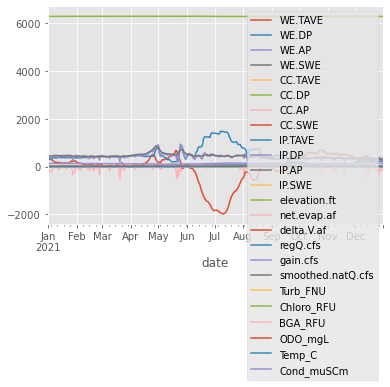

In [30]:
final_test.plot()

In [31]:
#creating the train and validation set
train = final_train_log.dropna()
valid = final_test_log.dropna()

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit(365)

# make prediction on validation
prediction = model_fit.forecast(model_fit.endog, steps=len(valid))

C:\Users\harri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [32]:
# #converting predictions to dataframe
# pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
# for j in range(0,6):
#     for i in range(0, len(prediction)):
#        pred.iloc[i][j] = prediction[i][j]

# #check rmse
# for i in cols:
#     print('rmse value for', i, 'is : ', np.sqrt(mean_squared_error(pred[i], valid[i])))

In [33]:
#make final predictions
model = VAR(endog=train.dropna())
model_fit = model.fit(365)
yhat = model_fit.forecast(model_fit.endog, steps=365)
print(yhat)

C:\Users\harri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


[[7.69415424 7.68282346 7.68852301 ... 7.68693467 7.68500386 7.7427986 ]
 [7.69356783 7.68310111 7.68561762 ... 7.68686827 7.68525655 7.7442404 ]
 [7.69611082 7.68305348 7.68645388 ... 7.68704759 7.6854341  7.746909  ]
 ...
 [7.68510894 7.68326215 7.68584053 ... 7.68755501 7.68452014 7.73519853]
 [7.70032479 7.68330207 7.68621462 ... 7.68702958 7.68441796 7.7381127 ]
 [7.70621816 7.68332365 7.68831199 ... 7.68630425 7.68419827 7.74284427]]


In [34]:
model_fit.endog_lagged

array([[1.        , 7.69256965, 7.68340368, ..., 7.68833882, 7.68516885,
        7.74648484],
       [1.        , 7.68753877, 7.68340368, ..., 7.68834594, 7.68517632,
        7.74667934],
       [1.        , 7.68845536, 7.68340368, ..., 7.68832293, 7.68524764,
        7.74718971],
       ...,
       [1.        , 7.6912001 , 7.68340368, ..., 7.68694123, 7.68548697,
        7.74267656],
       [1.        , 7.68937111, 7.68340368, ..., 7.68680274, 7.68549509,
        7.74278172],
       [1.        , 7.68891334, 7.68349576, ..., 7.68674954, 7.68550768,
        7.74276771]])

C:\Users\harri\AppData\Local\Temp\ipykernel_5124\1703906445.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(final_train['2020'])


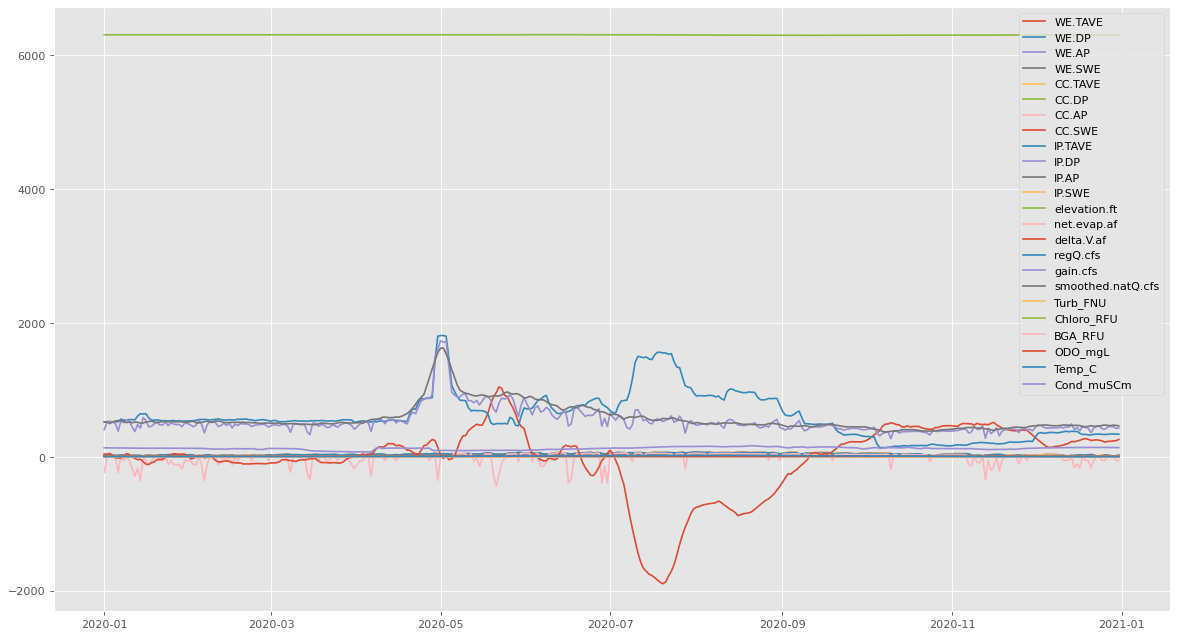

In [35]:
figure(figsize=(18,10), dpi=80)

plt.plot(final_train['2020'])
plt.legend(final_train)

In [36]:
yhat_unt = pd.DataFrame((np.exp(yhat))-2172)
yhat_unt.set_index(final_test.index, inplace=True)
yhat_unt.columns = final_test.columns
yhat_unt

,WE.TAVE,WE.DP,WE.AP,WE.SWE,CC.TAVE,CC.DP,CC.AP,CC.SWE,IP.TAVE,IP.DP,...,delta.V.af,regQ.cfs,gain.cfs,smoothed.natQ.cfs,Turb_FNU,Chloro_RFU,BGA_RFU,ODO_mgL,Temp_C,Cond_muSCm
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,23.476178,-1.259875,11.147700,6.212654,18.764627,-0.703377,5.645577,2.817585,34.319546,-0.632020,...,236.930075,284.613938,586.066158,426.671293,4.234152,2.188536,-0.369014,7.682856,3.478373,132.913904
2021-01-02,22.189106,-0.657093,4.813996,5.939483,18.555601,-0.093837,1.931726,2.741977,38.752135,-0.362348,...,185.796847,227.565018,436.839857,369.436086,4.486172,0.518828,-1.282768,7.538135,4.028164,136.239509
2021-01-03,27.776006,-0.760503,6.635139,5.654675,22.982500,0.080217,2.978301,2.707002,29.851503,-0.270570,...,99.458734,211.752906,380.177273,320.556344,4.403897,-0.607965,-1.268553,7.929004,4.414558,142.407522
2021-01-04,34.698788,-0.869546,12.267858,5.597390,29.097652,-0.067308,5.943940,2.755053,36.490533,-0.235858,...,-56.817893,119.843235,214.221502,306.773074,3.541864,-2.449591,-1.867481,7.724818,4.822750,148.617870
2021-01-05,38.001717,-0.384683,20.333256,5.960021,31.028817,0.333334,11.015121,3.234978,35.253809,-0.170519,...,-123.593526,11.475463,62.729308,252.150967,2.266270,0.463364,-1.592573,6.410645,5.033802,159.129880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,5.732763,0.481692,8.096230,6.213060,8.575081,0.315927,3.369080,2.589652,12.699735,0.053694,...,452.252009,321.494779,376.845175,406.198323,4.283424,5.120671,2.605310,8.918262,3.151062,106.112333
2021-12-28,1.485835,0.861385,4.883894,6.484200,1.577214,0.648407,2.001928,3.143956,1.713822,0.258063,...,645.184782,380.698996,420.588174,440.345137,5.393043,6.681460,1.685664,8.780500,2.902819,114.485124
2021-12-29,3.706985,-0.307388,5.299294,5.894133,2.758622,-0.351785,2.497213,2.930275,-2.018543,-0.478009,...,825.934076,408.057648,698.581649,435.227915,8.122105,4.151351,1.497393,9.035424,2.426295,115.462799


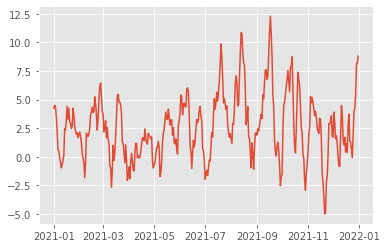

In [37]:
plt.plot(((yhat_unt['Turb_FNU'])), label='Predicted')

In [38]:
dibrinse = (final_test-yhat_unt)
dibb = dibrinse.sum()
mse = dibb/365
rmse = np.sqrt(mse)
rmse

#verify the right way to do this

C:\Users\harri\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


WE.TAVE              1.386838
WE.DP                0.552447
WE.AP                     NaN
WE.SWE                    NaN
CC.TAVE              1.469940
CC.DP                0.565091
CC.AP                     NaN
CC.SWE                    NaN
IP.TAVE              1.225996
IP.DP                0.572623
IP.AP                     NaN
IP.SWE                    NaN
elevation.ft              NaN
net.evap.af          0.750756
delta.V.af                NaN
regQ.cfs                  NaN
gain.cfs                  NaN
smoothed.natQ.cfs         NaN
Turb_FNU             1.332638
Chloro_RFU           0.676285
BGA_RFU              0.716176
ODO_mgL              0.735837
Temp_C               0.900165
Cond_muSCm           3.251065
dtype: float64

In [39]:
final_test

,WE.TAVE,WE.DP,WE.AP,WE.SWE,CC.TAVE,CC.DP,CC.AP,CC.SWE,IP.TAVE,IP.DP,...,delta.V.af,regQ.cfs,gain.cfs,smoothed.natQ.cfs,Turb_FNU,Chloro_RFU,BGA_RFU,ODO_mgL,Temp_C,Cond_muSCm
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,16.0,0.0,8.2,7.3,19.0,0.0,4.0,3.6,23.0,0.0,...,286.371429,336.0,473.218701,450.186231,4.062128,0.367234,0.577872,6.902447,3.568787,136.174468
2021-01-02,19.0,0.2,8.4,7.6,20.0,0.3,4.3,3.9,24.0,0.3,...,311.414286,331.0,395.996470,437.342115,4.080745,0.375833,0.578333,6.966354,3.563354,135.673958
2021-01-03,22.0,0.4,8.8,7.9,24.0,0.1,4.4,4.0,27.0,0.3,...,305.214286,329.0,390.736122,441.850473,4.290000,0.358333,0.582187,6.949583,3.566958,135.616667
2021-01-04,25.0,0.7,9.5,8.6,26.0,0.4,4.8,4.5,30.0,0.3,...,296.328571,317.0,374.016665,446.983281,4.392083,0.338125,0.583333,6.870833,3.595531,135.275000
2021-01-05,23.0,0.6,10.1,9.0,25.0,0.2,5.0,4.7,29.0,0.4,...,288.200000,335.0,359.163160,441.158729,4.609674,0.344130,0.589783,7.111739,3.626120,135.434783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,10.0,0.5,17.3,12.9,13.0,0.4,11.5,6.5,17.0,0.6,...,345.381446,217.0,227.585681,315.894845,6.513646,0.608750,-0.044271,7.552292,3.786125,133.888542
2021-12-28,2.0,0.0,17.3,13.0,3.0,0.0,11.5,6.5,9.0,0.0,...,333.787929,226.0,392.313095,308.990468,6.322292,0.511563,-0.044167,7.495729,3.791698,133.850000
2021-12-29,6.0,0.3,17.6,13.3,8.0,0.1,11.6,6.6,11.0,0.3,...,304.581729,229.0,299.410937,320.837058,6.224894,0.510319,-0.062872,7.367872,3.828872,134.678723


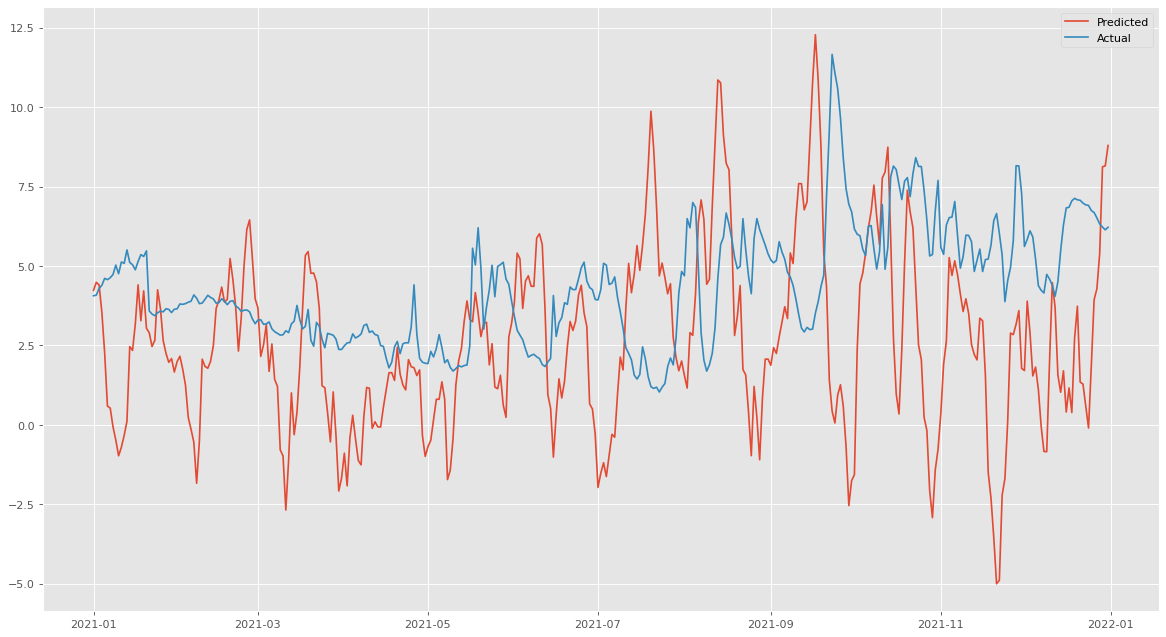

In [40]:
figure(figsize=(18,10), dpi=80)


plt.plot(yhat_unt['Turb_FNU'], label='Predicted')
plt.plot(final_test['Turb_FNU'], label='Actual')
plt.rcParams["figure.figsize"] = (20,3)
plt.legend()

In [41]:
yhat_unt['Turb_FNU'].corr(final_test['Turb_FNU']**2)

-0.047142765276430756

The above is the predicted values for Turbidity Using VAR. This result is if we were to predict the entire year without knowing any of the values for the predictor variables for the year. This shows that although the explanatory variables do contribute to the turbidity value, they themselves are not predictable for the time of year due to unpredictability in the environment, such as the weather.

In [42]:
yhat

array([[7.69415424, 7.68282346, 7.68852301, ..., 7.68693467, 7.68500386,
        7.7427986 ],
       [7.69356783, 7.68310111, 7.68561762, ..., 7.68686827, 7.68525655,
        7.7442404 ],
       [7.69611082, 7.68305348, 7.68645388, ..., 7.68704759, 7.6854341 ,
        7.746909  ],
       ...,
       [7.68510894, 7.68326215, 7.68584053, ..., 7.68755501, 7.68452014,
        7.73519853],
       [7.70032479, 7.68330207, 7.68621462, ..., 7.68702958, 7.68441796,
        7.7381127 ],
       [7.70621816, 7.68332365, 7.68831199, ..., 7.68630425, 7.68419827,
        7.74284427]])

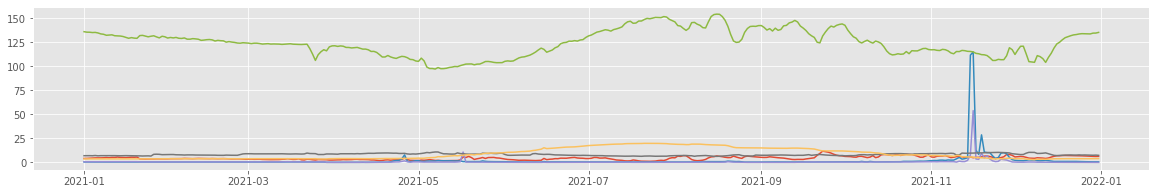

In [43]:
plt.plot(ipe_test)

In [44]:
# redo this within the scope of one dataset

jimmies = OLS(exog=yhat_unt, endog=final_test['Turb_FNU'])
jim = jimmies.fit()
print(jim.summary())

                                 OLS Regression Results                                
Dep. Variable:               Turb_FNU   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              243.2
Date:                Mon, 22 Aug 2022   Prob (F-statistic):                   2.21e-198
Time:                        13:48:15   Log-Likelihood:                         -557.31
No. Observations:                 365   AIC:                                      1163.
Df Residuals:                     341   BIC:                                      1256.
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [45]:
X_train = final_train.drop(['Turb_FNU'], axis=1)
y_train = final_train.Turb_FNU

In [46]:
X_test = final_test.drop(['Turb_FNU'], axis=1)
y_test = final_test.Turb_FNU

In [47]:
X_test_diff = X_test.diff()

As others have stated, you need to have a common frequency of measurement (i.e. the time between observations). With that in place I would identify a common model that would reasonably describe each series separately. This might be an ARIMA model or a multiply-trended Regression Model with possible Level Shifts or a composite model integrating both memory (ARIMA) and dummy variables. This common model could be estimated globally and separately for each of the two series and then one could construct an F test to test the hypothesis of a common set of parameters.

Use LSTM neuran network RNN

In [48]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

m = Sequential()
m.add(LSTM(units=50, return_sequences=True,
          input_shape=(X_train.shape[1],1)))
m.add(Dropout(0.2))
m.add(LSTM(units=50))
m.add(Dropout(0.2))
m.add(Dense(units=1))
m.compile(optimizer = 'adam', loss = 'mean_squared_error')


Epoch 1/50
37/37 [==============================] - 0s 11ms/step - loss: 3.1686
Epoch 2/50
37/37 [==============================] - 0s 11ms/step - loss: 3.1189
Epoch 3/50
37/37 [==============================] - 0s 11ms/step - loss: 2.9763
Epoch 4/50
37/37 [==============================] - 0s 11ms/step - loss: 3.1752
Epoch 5/50
37/37 [==============================] - 0s 11ms/step - loss: 3.2555
Epoch 6/50
37/37 [==============================] - 0s 11ms/step - loss: 3.0751
Epoch 7/50
37/37 [==============================] - 0s 11ms/step - loss: 3.0283
Epoch 8/50
37/37 [==============================] - 0s 11ms/step - loss: 2.9680
Epoch 9/50
37/37 [==============================] - 0s 11ms/step - loss: 2.8451
Epoch 10/50
37/37 [==============================] - 0s 11ms/step - loss: 2.9768
Epoch 11/50
37/37 [==============================] - 0s 11ms/step - loss: 2.9249
Epoch 12/50
37/37 [==============================] - 0s 11ms/step - loss: 2.8392
Epoch 13/50
37/37 [==================

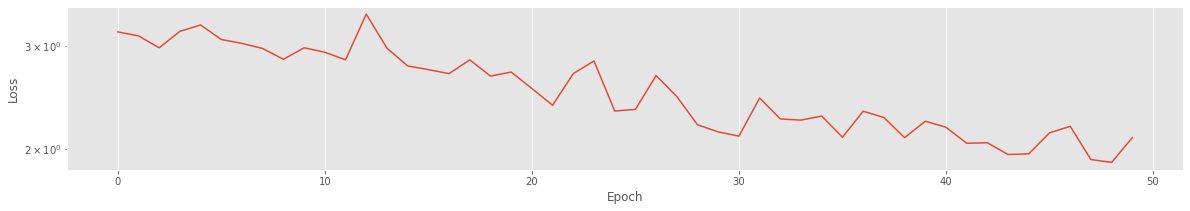

In [52]:
history = m.fit(X_train, y_train, epochs=50, batch_size=50, verbose=1)

plt.figure()
plt.ylabel('Loss'); plt.xlabel('Epoch')
plt.semilogy(history.history['loss'])

12/12 [==============================] - 0s 4ms/step


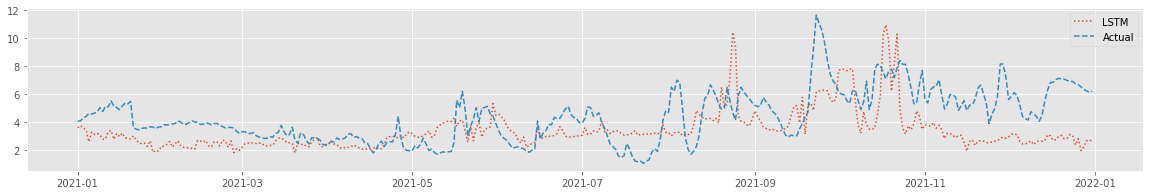

In [53]:
y_pred = m.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred.set_index(X_test.index, inplace=True)


plt.figure()
plt.plot(y_pred,':',label='LSTM')
plt.plot(y_test,'--',label='Actual')
plt.legend()

In [51]:
X_test_diff

,WE.TAVE,WE.DP,WE.AP,WE.SWE,CC.TAVE,CC.DP,CC.AP,CC.SWE,IP.TAVE,IP.DP,...,net.evap.af,delta.V.af,regQ.cfs,gain.cfs,smoothed.natQ.cfs,Chloro_RFU,BGA_RFU,ODO_mgL,Temp_C,Cond_muSCm
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,3.0,0.2,0.2,0.3,1.0,0.3,0.3,0.3,1.0,3.000000e-01,...,-168.273875,25.042857,-5.0,-77.222231,-12.844116,0.008599,0.000461,0.063907,-0.005433,-0.500510
2021-01-03,3.0,0.2,0.4,0.3,4.0,-0.2,0.1,0.1,3.0,0.000000e+00,...,-0.255490,-6.200000,-2.0,-5.260348,4.508357,-0.017500,0.003854,-0.016771,0.003604,-0.057292
2021-01-04,3.0,0.3,0.7,0.7,2.0,0.3,0.4,0.5,3.0,0.000000e+00,...,-0.247609,-8.885714,-12.0,-16.719456,5.132809,-0.020208,0.001146,-0.078750,0.028573,-0.341667
2021-01-05,-2.0,-0.1,0.6,0.4,-1.0,-0.2,0.2,0.2,-1.0,1.000000e-01,...,-56.578169,-8.128571,18.0,-14.853505,-5.824553,0.006005,0.006449,0.240906,0.030588,0.159783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,-6.0,-0.6,0.5,0.3,-6.0,0.2,0.4,0.4,-5.0,3.000000e-01,...,-160.339767,-5.377019,0.0,-83.542013,-3.024610,-0.099867,-0.017037,-0.110049,0.006859,-0.144437
2021-12-28,-8.0,-0.5,0.0,0.1,-10.0,-0.4,0.0,0.0,-8.0,-6.000000e-01,...,319.993197,-11.593517,9.0,164.727414,-6.904377,-0.097187,0.000104,-0.056562,0.005573,-0.038542
2021-12-29,4.0,0.3,0.3,0.3,5.0,0.1,0.1,0.1,2.0,3.000000e-01,...,-160.640472,-29.206200,3.0,-92.902158,11.846590,-0.001243,-0.018706,-0.127857,0.037174,0.828723
